In [ ]:
import numpy as np
import pandas as pd
import skimage 
import cv2
import matplotlib.pyplot as plt
import os
from skimage.feature import hog
import time
from skimage import io, data, color, exposure, feature
from skimage.transform import rescale, resize, downscale_local_mean
from cv2 import IMREAD_GRAYSCALE
from google.colab.patches import cv2_imshow

In [ ]:
def load_data(data_dir):
    """
        Load the data to be predicted.
        Returns: tuple (images, counts)
        images: list of images as numpy array
        brands: list of brands for each corresponding image
    """
    original_img=[]
    images = []
    brands = []
    for root, dir_names, filenames in os.walk(data_dir):
        #print(filenames)
        #print("Inside for 1")
        for file_ in filenames:
            #print(str(file_))
            image = cv2.imread(os.path.join(root, file_))
            original_image=cv2.resize(image,(500,500))
            original_img.append(original_image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #cv2_imshow(image)
            image=image.astype(np.float32)
            image=cv2.resize(image,(500,500))
            images.append(image)
            brand_name = (os.path.join(root,file_)).split("/").pop(-2)
            brands.append(brand_name)
    #brands += ['Burger King','KFC','McDonalds','Star bucks','Subway']
    #print(brands)
    return (images, brands,original_img)



In [ ]:
def pyramid(image, scale=0.9, minSize=(128, 128)):
  
   
    images = []
    current_scale = 1.0
    images.append(image)
    i=0
    #print(image.shape)
    h,w=image.shape
    while h>minSize[0] and w>minSize[1]:
      i=i+1
      h=int(h*(scale**i))
      w=int(w*(scale**i))
      img=cv2.resize(image,(h,w))
      #print(type(img))
      images.append(img)
      #cv2_imshow(img)
      #print(img)
    return images

In [ ]:
def process_template(template):
    """
    returns : processed template
    """
    t=cv2.resize(template,(64,64))
    t=t-np.mean(t)
    t = np.uint8(t)
    t=cv2.Canny(t,50,200)
    #cv2_imshow(t)
    return t

In [ ]:
def load_templates(data_dir):
    """
    returns: array conatining templates and brands
    """
    templates = []
    brands = []
    template = np.zeros((3,3))
    index = 0
    for root, _, filenames in os.walk(data_dir):
        for file_ in filenames:
            t = cv2.imread(os.path.join(root, file_))
            t = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)
            t=t.astype(np.float32)
            template = process_template(t)
            #cv2_imshow(template)
            templates.append(template)
            brand_name = (os.path.join(root,file_)).split("/").pop(-2)
            brands.append(brand_name)
        index +=1 
    #brands=['Burger King','KFC','McDonalds','Star bucks','Subway']
    return (templates, brands)

In [ ]:
def pre_process_image(img):
    """
    Returns:  pyramid of  image 
    ex normalization
    """
    img=cv2.GaussianBlur(img,(3,3),0)
    img=pyramid(img)
    for image in img:
      image= np.uint8(image)
      #print(image)
      image=cv2.Canny(image,50,200)
      #print(image)
      #cv2_imshow(image)
    return img


In [ ]:
def template_match(image,templates):
    """
    Returns the score of temaplate matching
    Ex: cv2.matchTemplate(image, template, methods)
    hog
    """
   
    max=0
    idx=None
    
    #hog_score_temp=hog(image,orientations=9)
    #print(type(templates[0]))
    image=image.astype(np.float32)
    for i in range(len(templates)):
      templates[i]=templates[i].astype(np.float32)
      templates[i]=templates[i]-np.mean(templates[i])
      #print(templates[i].shape)
      #print(image.shape)
      res = cv2.matchTemplate(image, templates[i], cv2.TM_CCOEFF)
      #res = cv2.matchTemplate(image,templates[i],)
      min_val, score, min_loc, max_loc = cv2.minMaxLoc(res)
      #score=sliding_window(image,hog_feature[i],20,(128,64))
      #score=np.max(result)
      #print(score)
      if score>max:
          max=score
          idx=i
    #print(max,idx)
    return (max,idx)   

In [ ]:
def main(img_dir_path, temp_dir_path):
    """
    Function to control flow of the model
    Returns :nothing
    """
    (images, brands2,original_img) = load_data(img_dir_path)
    #print(str(brands))
    (templates, brands) = load_templates(temp_dir_path)
    predictions = []
    for image in (images):
        #cv2_imshow(image)
        pyramid = pre_process_image(image)
        max_score = 0
        pred_brand = None
        curr_score= None
        for img in pyramid:
          #print(type(img))
          curr_score,idx=template_match(img,templates)
          #max_score = (curr_score > max_score and curr_score) or max_score
          if curr_score > max_score:
            #print(idx,curr_score)
            max_score = curr_score
            pred_brand = idx
        pred_brand = brands[pred_brand]
        predictions.append(pred_brand)
    for i in range(len(images)):
      cv2_imshow(original_img[i])
      print(predictions[i])
      print("\n")


    


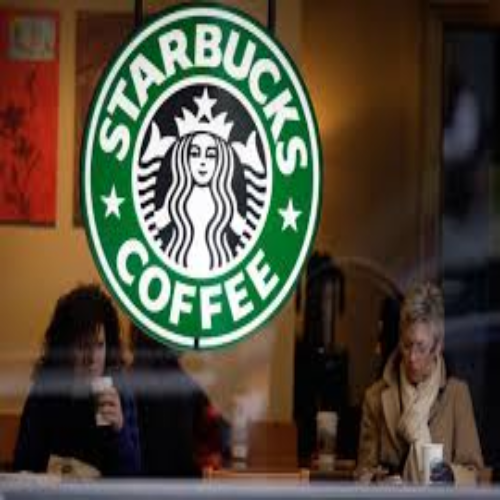

Starbucks




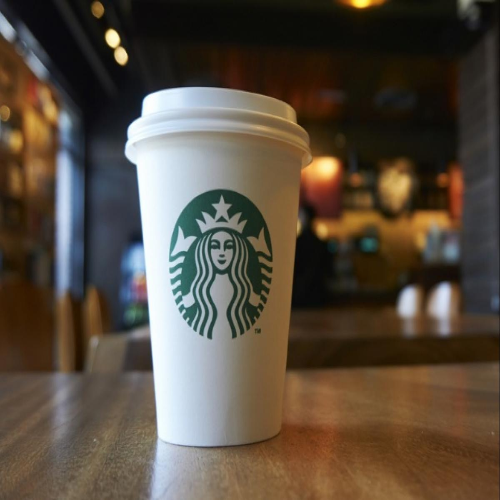

Starbucks




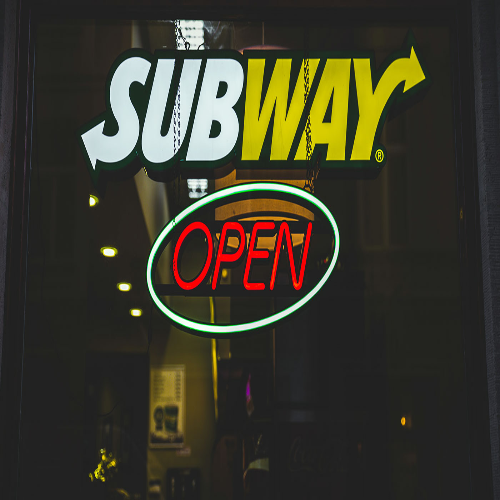

subway




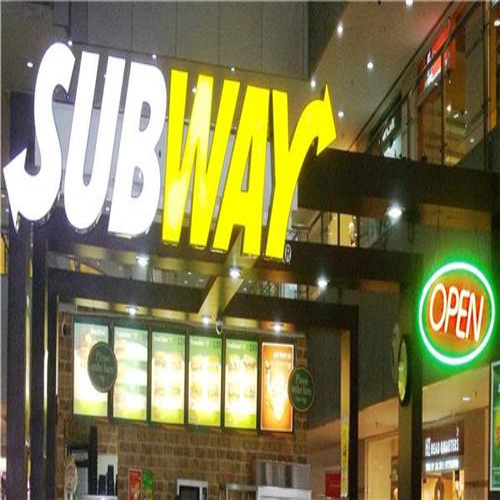

subway




In [ ]:
#if namespace == "__main__":
main( "/content/testdata","/content/template")